# Coupling of modes + circuit analysis

The purpose of the coupling of modes theory is to get us an electrical element that responds in an equivalent manner to a SAW resonator. To model an experiment, we need to take this equivalent electrical element and model how it will interact with other elements of the experiment (in this case, the qubit.) This notebook walks through how I've done this.

In addition to ```sawcom```, I've created another .py file name ```comcirc``` which is just a collection of functions that help out with modeling the experiment. Let's load those up so we can see how they work.

In [1]:
%matplotlib inline
# comment out is command-/

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import sawcom as sc
import comcirc as cc

## 128˚ Y-X SAW resonator model

This resonator model reflects the example resonator layed out in Chapter 6 of my thesis, and much of the code here actually produces some of the figures in Chapter 6.

In this example model, the IDTs have a center frequency $\lambda = 900$ nm, an overlap length of $35~\mu$m, and $N_p = 16$. The mirrors start a half wavelength away from the IDTs, and have a 2x periodicity $\lambda = 916$ nm. There's 525 Bragg gratings on either side of the IDT. The device was fabricated on 128˚ Y-X lithium niobate.

In [3]:
# Device design parameters

lam = 900E-9 # Wavelength in m
lam_mir = 912E-9
w = 35E-6 # finger overlap in meters
n_idt = 16 # number of finger pairs in IDT
len_blank = 450E-9 #distance between mirrors and IDT
n_grating = 525 #number of Bragg gratings

# Material parameters

v = 3979 # velocity in m/s (at 10 mK)
#vblank = 3979 # velocity in m/s of the unloaded area (at 10 mK)
ksquared = 0.054
c_s = 5 # IDT capacitance per unit length (pF/cm)
w_cm = w*1E2 # convert to cm in the code because I'm a fucking idiot and can't do it by myself
a1 = sc.a1_finder(v, lam, ksquared, c_s, w) 

The speed of sound will be slightly different in the loaded ares (places with IDTs/gratings) and the undloaded areas (free propagation). In this device, there isn't really any unlodad area, so we'll igonre differences in that for now.

a1 is a phenomenological parameter that scales the conductance for a given set a parameters to match the numberical values given in the Superconducting Devices for Quantum Optics book. c_s is the IDT capacitance in pF/cm. The capacitance is the only thing that gets quoted in cm, because pF/cm generally gives humanish numbers on SAW substrates.

Each element of the P-matrix is a function of frequency. It turns out that a useful thing to have is the wave number at a given frequency *relative to the center frequency of the structure the SAW is propagating through*. Therefore, we define two wave number arrays: one for the IDT, and one for the mirrors. We could also define one for a blank spot if we needed to.

We also model propagation loss by making the wave number complex. As far as I know, propoagation losses of SAW substrates have never really been systematically measured at dil fridge temperatures, so this is somewhat of a shot in the dark. I've found this value generally gives $Q\approx 10^4$. 

We also need the reflectivity per unit length $c_{12}$, i.e. the reflectivity per grating / lenth of a grating.

In [8]:
proploss = 500 #in Np/m

freq = np.linspace(4.2E9, 4.6E9, 10001)
d = sc.delta(freq,v,lam) -proploss*1j
#d_blank = sc.delta(freq,vblank,lam) - 500j
d_mirror = sc.delta(freq,v,lam_mir) - proploss*1j

r = -0.015j # Reflection per grating
c12 = r/(lam/2) # Reflectivity per unit length (~1.5% reflected per grating spaced at lam/2)

Given all these parameters, we can now construct the P-matrix for a given component using the ```SAW_COM.sawcom``` module command ```sc.pmatrix(lam, c12, a1, length, wavenumber)```

In [7]:
# Get the P-matrix for each individual component

idt25_ref = sc.pmatrix(lam,c12,a1,lam*n_idt,d) #transducer
mirror =  sc.pmatrix(lam_mir,c12,0,lam_mir*n_grating/2,d_mirror) #mirror
blank = sc.pmatrix(lam,0,0,len_blank,d) # free propagation path)

```SAW_COM.sawcom``` has a command for cascading the P-matrices of two elements together: ```sc.concat(pmat1,pmat2)```. The first argument is the P-matrix of the *left* element, and the argument is the P-matrix of the *right* argument. This spits out the cascaded P-matrix of the two elements.

In [6]:
# Cascade P-matrices into resonator P-matrix
dict_2 = {'t':idt25_ref, 'm':mirror, 'b':blank}
str_2 = 'mbtbm'
res2 = dict_2[str_2[0]]
for i in range(1,len(str_2)):
    res2 = sc.concat(res2,dict_2[str_2[i]])

Let's plot $P_{33}$ as a function of frequency and see what we find! Note that in the P-matrix generated by ```sc.pmatrix```, $P_{33}(f) = Y(f)$ doesn't include the admittance associated with the geometric capacitance of the SAW IDT. If you want to include that, you have to add it in manually.

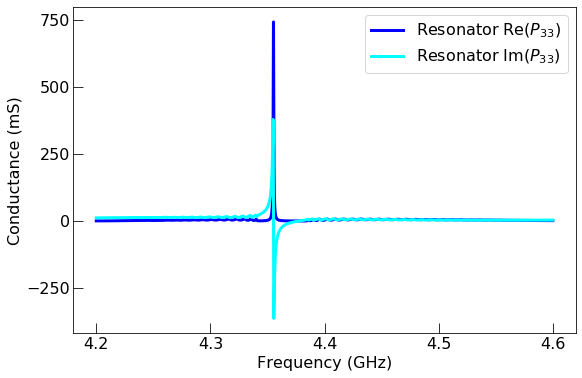

In [9]:
geom_cap = c_s*n_idt*w*1E-10 #Geometric capacitance to add that in manually

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,6))
fsz = 16
fplot = freq/1E9
lns1 = ax.plot(fplot,np.real(res2.p33*1E3), color = 'blue', 
               linewidth = 3, label = 'Resonator Re($P_{33}$)')
lns2 = ax.plot(fplot,np.imag(res2.p33*1E3)+2*np.pi*freq*geom_cap*1E3, color = 'cyan', 
               linewidth = 3, label = 'Resonator Im($P_{33}$)')
ax.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)
#ax2.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)
ax.legend(fontsize = fsz)
ax.set_xlabel('Frequency (GHz)', size = fsz)
ax.set_ylabel('Conductance (mS)', size = fsz)
plt.locator_params(nbins=5)

#plt.savefig('Y_LiNbO3_040821.png',bbox_inches='tight', transparent = True, dpi = 200)

# Fitting to the Butterworth-van Dyke equivalent

Now, the goal is to fit this to it's BvD equivalent circuit. This is most accurately done inside the mirror stopband, where the compicated frequency dependence admittance associated with the mirrors is suppressed and the admittance looks like one (or more) resonances. To do so, we need the arguments of ```freq``` that delimit the beginning and end of the stopband. If we remember that the stopband $\Delta f_{stop} / f_0 \approx 2\pi*|r|$, this becomes straightforward to estimate

In [10]:
mirror_center = v/lam_mir
stopbandw = mirror_center*2*np.abs(r)/np.pi

startband = mirror_center - stopbandw/2
endband = mirror_center + stopbandw/2

startarg = np.argmin(np.abs(freq - startband))
endarg = np.argmin(np.abs(freq - endband))

Plotting over these arguments verifies that we've found the stopband

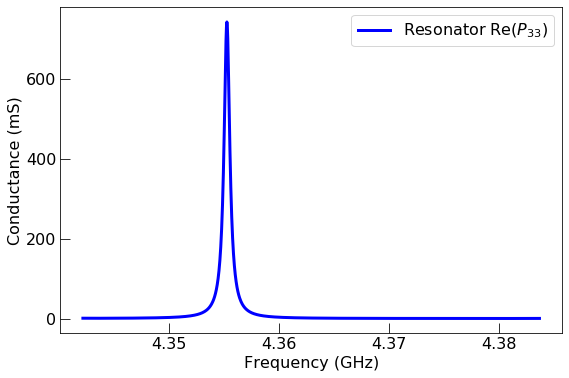

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,6))

fsz = 16
fplot = freq/1E9

lns1 = ax.plot(fplot[startarg:endarg],np.real(res2.p33*1E3)[startarg:endarg], color = 'blue', 
               linewidth = 3, label = 'Resonator Re($P_{33}$)')

ax.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)
ax.legend(fontsize = fsz)
ax.set_xlabel('Frequency (GHz)', size = fsz)
ax.set_ylabel('Conductance (mS)', size = fsz)
plt.locator_params(nbins=5)

Now we fit to the BvD equivalent. 

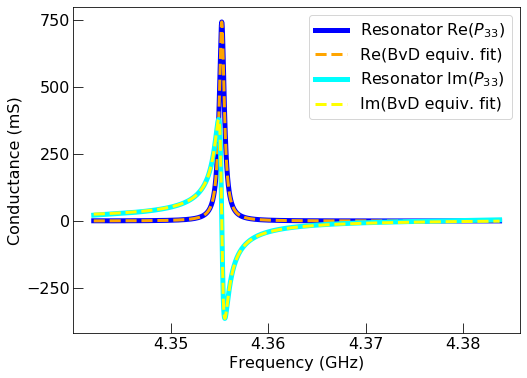

In [16]:
# Define fit function for the real part of the admittance of a BvD equivalent circuit
def BVD(f, f0, R, C):
    w = 2*np.pi*f
    w0 = 2*np.pi*f0
    L = 1/(w0**2*C)
    return R*(w*C)**2/((R*w*C)**2 + (1-L*C*w**2)**2)

# Fit over only the mirror stopband
ffit = freq[startarg:endarg]
Gfit = np.real(res2.p33)[startarg:endarg]

# Fit to the function
popt, popc = op.curve_fit(BVD, ffit, Gfit, [4.35E9, 100, 1E-15] )



# Verity fit worked
BVDfit = BVD(ffit, popt[0], popt[1], popt[2])

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
fsz = 16
fplot = freq/1E9
ax.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)
ax.set_xlabel('Frequency (GHz)', size = fsz)
ax.set_ylabel('Conductance (mS)', size = fsz)
plt.locator_params(nbins=5)


lns1 = ax.plot(ffit/1E9,Gfit*1E3, color = 'blue',linewidth = 5, label = 'Resonator Re($P_{33}$)')
lns2 = ax.plot(ffit/1E9,BVDfit*1E3, color = 'orange',linewidth = 3, 
               linestyle = '--', label = 'Re(BvD equiv. fit)')

#For good measure, let's also plot the imaginary part, and a fit to the imaginary componenet
def BVDimag(f, f0, R, C):
    w = 2*np.pi*f
    w0 = 2*np.pi*f0
    L = 1/(w0**2*C)
    return (C*w - C**2*L*w**3)/((C*R*w)**2 + (1-C*L*w**2)**2)

BVDifit = BVDimag(ffit, popt[0], popt[1], popt[2])
Bfit = np.imag(res2.p33)[startarg:endarg]

lns3 = ax.plot(ffit/1E9,Bfit*1E3 + 2*np.pi*ffit*geom_cap*1E3, 
               color = 'cyan',linewidth = 5, label = 'Resonator Im($P_{33}$)')
lns4 = ax.plot(ffit/1E9,BVDifit*1E3 + 2*np.pi*ffit*geom_cap*1E3, color = 'yellow',linewidth = 3, 
               linestyle = '--', label = 'Im(BvD equiv. fit)')

ax.legend(fontsize = fsz)
#plt.savefig('Y_LiNbO3_040821_BvDfits.png',bbox_inches='tight', transparent = True, dpi = 200)

This fit gives us the effective mechanical L, R, and C

In [14]:
Rm = popt[1]
Cm = popt[2]
Lm = 1/((2*np.pi*popt[0])**2*Cm)

print('The mechanical resistance Rm = '+str(Rm)+' ohms')
print('The mechanical capacitance Cm = '+str(Cm)+' F')
print('The mechanical inductance Lm = '+str(Lm)+' H')
print(popt[0])

The mechanical resistance Rm = 1.3453762243139002 ohms
The mechanical capacitance Cm = 3.950554492689793e-15 F
The mechanical inductance Lm = 3.3803185829935026e-07 H
4355241951.39091


```SAW_COM.comcirc``` has a function that performs all of the above anaylsis for us, i.e. for a given set of SAW parameters, it spits out a BvD equivalent circuit, without having to go through all the steps above. This requires defining a ```device_dictionary``` that contains the relevant parameters for the SAW device. 

[1.34537623] [3.95055449e-15] [3.38031858e-07]


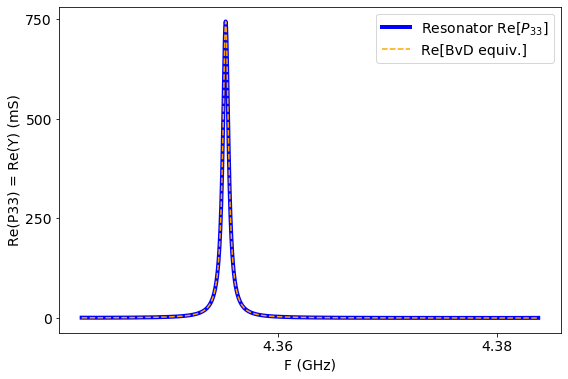

In [17]:
device_dict = {'IDTlam':lam , 'Mirrorlam':lam_mir , 'IDTlen':'na', 'Mirrorlen':'na' , 
               'FreelenR':'na' , 'FreelenL':'na', 'v':v, 'c12':c12, 'a1':a1}
device_dict['IDTlen'] = device_dict['IDTlam']*n_idt
device_dict['Mirrorlen'] = device_dict['Mirrorlam']*n_grating/2
device_dict['FreelenR'] = len_blank
device_dict['FreelenL'] = len_blank

G, sba = cc.generate_G(freq, device_dict, proploss*1j, plot = False)

# Fit and get the BvD equivalents
Rm,Cm,Lm, = cc.BvD_finder(freq, G ,sba, plot = True)
print(Rm,Cm,Lm)


### Circuit model coupling to the qubit

Now that we can model a resonator and extract the BvD equivalent elements with ease, we have to combine this with the qubit circuit to figure out the total admittance of the linear portion of the circuit, which will tell us about the Hamiltonian. The way I orignially did this was by simulating this circuit in SPICE, and finding the zeros as a function of $L_J$. However, this is a fairly simple linear circuit, wich means it's analyitically solvable, even if the anylitic solution is gross. Using the power of computers, we can do it!

Let's take an example circuit to connect to our BvD circuit. The capacitance values were obtained from finite element simulations of the non-SAW structure. The value for the Josephson inductance is a reasonable value for a superconducting qubit: since we can tune the Josephson inductance with an external flux, finding this exact value is in theory obtainable on a given cooldown.

For the total capacitance between the two leads of the SAW structure, we use the IDT geometric capacitance + a parallel value estimated from finite element simulations

In [18]:
Lj = 12E-9
Cj = 16.5E-15
Cp = 33.6E-15
C1 = 124E-15
Csaw = 171E-15 +  geom_cap # IDT capacitance + non-IDT geometric capacitance
#print(Csaw)

Now we're in a position to simulate the circuit, having all the lumped element values. The code below calculates the impedance of each element for a list of frequencies, and then transforms the circuit into one effective impedance between the two nodes of the Josephson junction. 

In [19]:
fcirc = np.linspace(4E9,5E9,1001)
Z1 = cc.parallel(cc.Zind(Lj,fcirc),cc.Zcap(Cj,fcirc))
Z2 = cc.Zcap(C1, fcirc)
Z3 = cc.Zcap(Cp, fcirc)
Z4 = cc.ZBvD(fcirc, Rm, Lm, Cm, Csaw)

Za, Zb, Zc = cc.delta_to_Y(Z3, Z4, Z2)

Z3c = Z3 + Zc
Z2a = Z2 + Za

Zn = cc.parallel(Z3c, Z2a)
Znb = Zn + Zb
Zf = cc.parallel(Z1, Znb)

At the end of the day, we care about the zeros of the imaginary part of the admittance, so we calulate ```np.imag(1/Z)``` and find the zeros of this function. The following code does that.

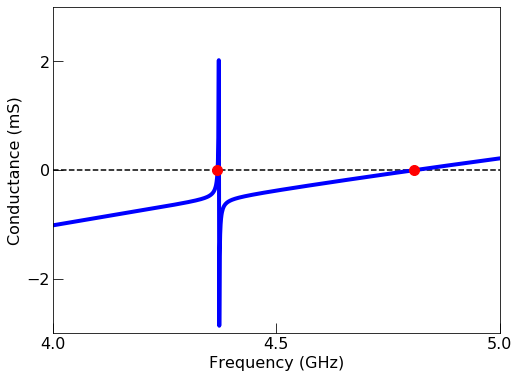

In [20]:
Y_array = np.imag(1/Zf)

f_zeros = np.empty(1) #creates an 'empty' array, which actually has one element 
fstep = fcirc[1]-fcirc[0] #find the frequency step

temp = np.where(np.diff(np.signbit(Y_array)))[0]
#print(temp)
for j in temp:
    delta = Y_array[j+1] - Y_array[j]
    #print(delta)
    if delta > 0:
        #print(j)
        f_zeros = np.append(f_zeros,[fcirc[j] - fstep*(abs(Y_array[j])/delta)])

f_zeros = f_zeros[1:] #Get's rid of first element of 'empty array'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
fsz = 16

ax.plot(fcirc/1E9, Y_array*1E3, color = 'blue',linewidth = 4)
ax.plot(f_zeros/1E9, [0,0], 'ro', markersize = 10)
ax.hlines(0,4,5, linestyle = 'dashed')

ax.set_xlim(4,5)
ax.set_ylim(-3,3)
ax.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)
ax.set_xlabel('Frequency (GHz)', size = fsz)
ax.set_ylabel('Conductance (mS)', size = fsz)
plt.locator_params(nbins=3)

#plt.savefig('lincirc_Y_vs_f.svg',bbox_inches='tight', transparent = True, dpi = 200)

The name of the game will then be to sweep over many values of $L_J$ so build the eignevalue specturm as a function of $L_J$. From this we can extract both the effective capacitance of the transmon mode $C_{eff}$ as well as the transmon-SAW coupling $g$. ```SAW_COM.comcirc``` has a function that does this, as well as a function that extracts the zeros of the imagniary parts of the admittances for each value $L_J$

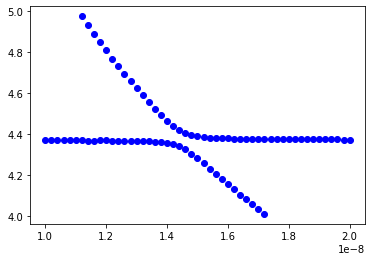

In [21]:
#print(geom_cap)
C12 = 16.5E-15 #Cj, parallel capacitance
C13 = 33.6E-15 #parasitic capacitance
C24 = C13 # to rounding errors, assuming symmetry
C14 = 124E-15 #parallel plate capacitance
C23 = C14 # to rounding errors, assuming symmetry
C34 = 171E-15 +  geom_cap # IDT capacitance + non-IDT geometric capacitance

cparams = {'csaw': C34,
           'cj': C12,
           'c1_1':  C14,
           'c1_2': C23,
           'cp_1': C13,
           'cp_2': C24}

Larray = np.linspace(10E-9,20E-9,51)
x = cc.Y_vs_Landf_capcup(fcirc,Larray, Rm, Lm, Cm, cparams)

fz, lz = cc.Y_zero_finder(np.imag(x), fcirc, Larray)
#plt.contourf(np.imag(x))
plt.plot(lz, fz/1E9, 'bo')

This looks like we're getting somewhere! There's an avoided crossing there, alright. All we need to do is fit to it to extract $E_C$ and $g$. This fit is frustratingly nontrivial, since we need to fit only *one* of the bands. I've made several functions in ```comcirc``` that help us out here. The first thing to do is to generate some guesses for the fit parameters, and then split the two bands into an upper and a lower band.

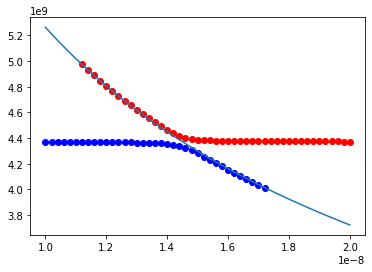

In [22]:
fsaw = float(1/(2*np.pi*np.sqrt(Cm*Lm))) # note that here the function should fail if n SAW resonances != 1
g_guess = 10E6
cap_guess = cc.Tmon_mode_cap_guess(fz,lz, fsaw)
    
fminus, lminus, fplus, lplus = cc.band_split(fz, lz, fsaw, cap_guess)

#plot the bands to make sure they got split
plt.plot(lminus,fminus, 'bo')
plt.plot(lplus, fplus, 'ro')

#also plot the resonant frequency of the uncoupled transmon mode as a function of Lj
plt.plot(lz, 1/(2*np.pi*np.sqrt(lz*cap_guess)))

And now, for the actual fit

(10.0, 20.0)

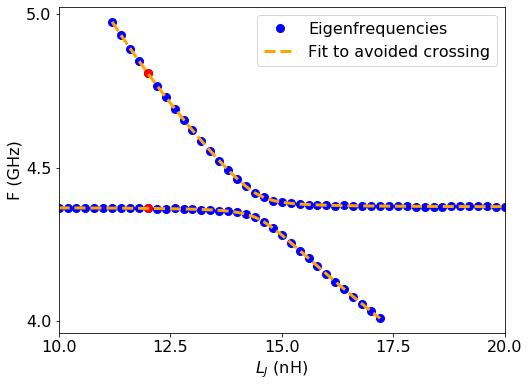

In [23]:
popt, popc =  op.curve_fit(cc.minus_band, lminus, fminus, p0 = [fsaw, g_guess, cap_guess])


f_fitm =cc.minus_band(lminus, popt[0], popt[1], popt[2])
f_fitp =cc.plus_band(lplus, popt[0], popt[1], popt[2])

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
ax.plot(lz*1E9,fz/1E9, 'bo', markersize = 8, label = "Eigenfrequencies")
ax.plot([12, 12], f_zeros/1E9, 'ro', markersize = 8)
ax.plot(lminus*1E9,f_fitm/1E9, color = 'orange', linestyle = 'dashed', 
        linewidth = 3, label = "Fit to avoided crossing")
ax.plot(lplus*1E9,f_fitp/1E9, color = 'orange', linestyle = 'dashed', 
        linewidth = 3)#, label = "Fit to avoided crossing")

ax.legend(fontsize = fsz)
ax.set_xlabel(r'$L_J$ (nH)', size = fsz)
ax.set_ylabel('F (GHz)', size = fsz)
ax.tick_params(labelsize = fsz)
ax.set_xlim([Larray[0]*1E9, Larray[-1]*1E9])

#plt.savefig('lincirc_eigen_fit.svg',bbox_inches='tight', transparent = True, dpi = 200)

The fit fits the data extremely well. The fit parameters are the Hamiltonian parameters we're looking for.

In [24]:
print('The SAW-qubit coupling is g='+str(popt[1]/1E6) + ' MHz')
print('The qubit mode capacitance is '+str(popt[2]*1E15)+ ' fF')

The SAW-qubit coupling is g=38.81212889028286 MHz
The qubit mode capacitance is 91.4529696059923 fF


```comcirc``` has a function that does all of this (finding the zeros, splitting into bands, and fitting them to an avoided crossing) in one go. Note that, right now, it only works for a single avoided crossing (i.e. a single SAW resonance.) In the future, I would like to expand it to multiple resonances, though the analysis might stray further away from reality the more resonances we have.

The SAW-qubit coupling is g=38.81212889028286 MHz
The qubit mode capacitance is 91.4529696059923 fF


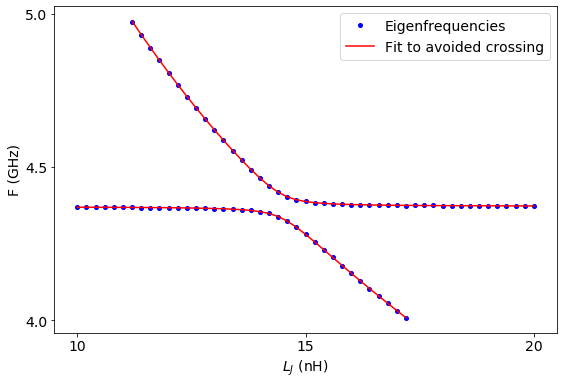

In [25]:
temp = cc.single_crossing_g_finder(x, fcirc, Larray, Rm, Lm, Cm, plot = True)
print('The SAW-qubit coupling is g='+str(temp[1]/1E6) + ' MHz')
print('The qubit mode capacitance is '+str(temp[2]*1E15)+ ' fF')

We can now use this function to calculate $g$ and $C_{eff}$ for a variety of circuit parameters. Here's the code that generates the contour plot in my thesis.

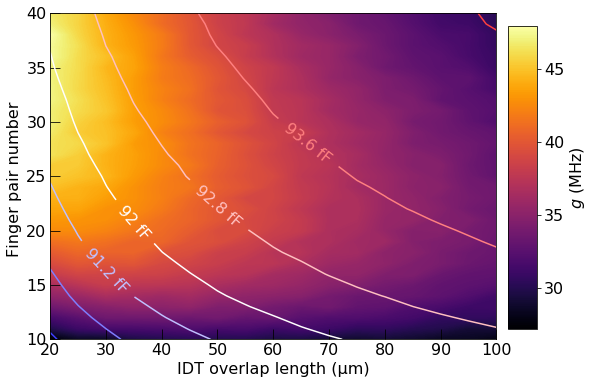

In [26]:
np_array = np.linspace(10,40,31)#31
w_array = np.linspace(20,100, 17)/1E6 #41
a1_array = sc.a1_finder(v, lam, ksquared, c_s, w_array)
#print(a1_array)

Larray = np.linspace(10E-9,20E-9,201)

cap_array = np.zeros([len(np_array),len(w_array)])
g_array = np.zeros([len(np_array),len(w_array)])

device_dict = {'IDTlam':lam , 'Mirrorlam':lam_mir , 'IDTlen':'na', 'Mirrorlen':'na' , 
               'FreelenR':'na' , 'FreelenL':'na', 'v':v, 'c12':c12, 'a1':a1}
device_dict['IDTlen'] = device_dict['IDTlam']*n_idt
device_dict['Mirrorlen'] = device_dict['Mirrorlam']*n_grating/2
device_dict['FreelenR'] = len_blank
device_dict['FreelenL'] = len_blank

cparams = {'csaw': 171E-15,
           'cj': C12,
           'c1_1':  C14,
           'c1_2': C23,
           'cp_1': C13,
           'cp_2': C24}

for i in range(len(np_array)):
    for j in range(len(w_array)):

        device_dict['a1'] = a1_array[j]
        device_dict['IDTlen'] = device_dict['IDTlam']*np_array[i]
        device_dict['Csaw'] = 171E-15 + c_s*w_array[j]*np_array[i]/1E10 # IDT geometric capacitance in Farads
        cparams['csaw'] = device_dict['Csaw']
        #print(cparams['csaw'])

        freq = np.linspace(4.3E9, 4.5E9, 5001)

        G, sba = cc.generate_G(freq, device_dict, 1j*proploss)#, plot = True)
        r,c,l = cc.BvD_finder(freq,G,sba)#, plot = True)

        x = cc.Y_vs_Landf_capcup(fcirc,Larray, r, l, c, cparams)
        temp = cc.single_crossing_g_finder(x, fcirc, Larray, r, l, c)#, plot = True)
        cap_array[i,j] = temp[2]
        g_array[i,j] = temp[1]

fig, axs = plt.subplots(figsize = (8,6))


p = axs.contourf(w_array*1E6, np_array, g_array/1E6, 500, cmap = 'inferno')
q = axs.contour(w_array*1E6, np_array, cap_array*1E15, cmap = 'bwr')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return  f"{s} fF"

axs.clabel(q, inline=1, fmt = fmt, fontsize=fsz)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
cb = fig.colorbar(p, cax=cbar_ax, ticks = [30, 35, 40, 45])
cb.ax.tick_params(labelsize = fsz)
cb.set_label(label = '$g$ (MHz)', size = fsz)
axs.set_xlabel('IDT overlap length (µm)', size = fsz)
axs.set_ylabel('Finger pair number ', size = fsz)
axs.tick_params(axis = 'both', direction = 'in', length = 10, labelsize = fsz)

# plt.savefig('LiNbO3_128YX_coupling_contours_250x250pads_z10um.png',
#             bbox_inches='tight', transparent = True, dpi = 200)
        
        
        